# Cis affected genes locations

This notebook plots the locations of the genes for proteins that are cis-affected, to see if they happen to be close to each other and thus possibly co-regulated.

In [1]:
import cnvutils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
# Load parameters
gen_params = cnvutils.load_params(os.path.join("..", "..", "..", "data", "gen_params.json"))
PANCAN = gen_params["PANCAN"]

chr_params = cnvutils.load_params(os.path.join("..", "..", "data", "chr_params.json"))
CHROMOSOME = chr_params["CHROMOSOME"]

arm_params = cnvutils.load_params(os.path.join("..", "data", "arm_params.json"))
ARM = arm_params["ARM"]
EVENT_START = arm_params["START"]
EVENT_END = arm_params["END"]

# Set cis or trans
CIS_OR_TRANS = "cis"

In [3]:
read_path = os.path.join(
    "..", 
    "data", 
    f"chr{CHROMOSOME}{ARM}_{CIS_OR_TRANS}_00_pearson_{'harmonized' if PANCAN else 'AWG'}.tsv"
)
data = pd.read_csv(read_path, sep='\t')

In [4]:
sig_pvalues = data[(data.type == 'rvalue') & (data.omics == 'proteomics') & (data.value >= 0.5)]
non_sig_pvalues = data[(data.type == 'rvalue') & (data.omics == 'proteomics') & (data.value <= 0.1)]

In [5]:
sig_genes = dict()
all_types = None
for cancer_type in sig_pvalues.cancer.unique():
    df = sig_pvalues[(sig_pvalues.cancer==cancer_type)]
    df_genes = set(df.Name)
    if all_types == None:
        all_types = df_genes
    else:
        all_types = all_types & df_genes
    sig_genes[cancer_type] = list(df_genes)
sig_genes['all'] = list(all_types)

In [6]:
non_sig_genes = dict()
all_types = None
for cancer_type in non_sig_pvalues.cancer.unique():
    df = non_sig_pvalues[(non_sig_pvalues.cancer==cancer_type)]
    df_genes = set(df.Name)
    if all_types == None:
        all_types = df_genes
    else:
        all_types = all_types & df_genes
    non_sig_genes[cancer_type] = list(df_genes)
non_sig_genes['all'] = list(all_types)

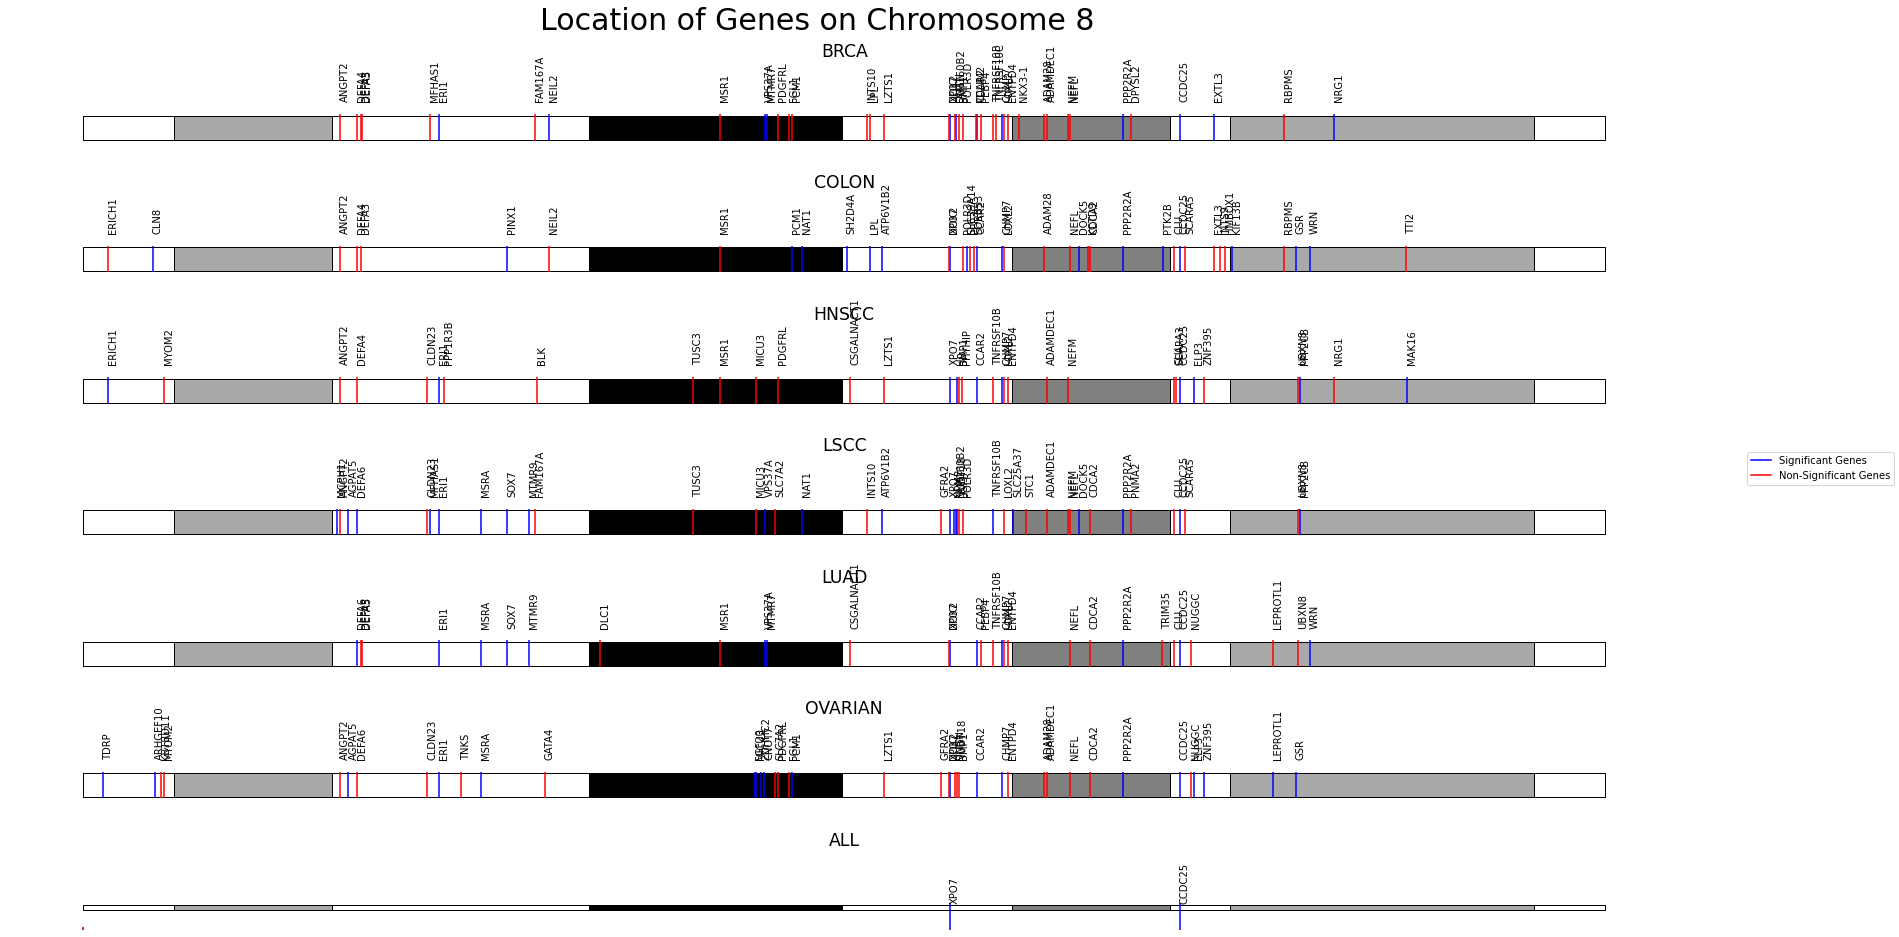

In [7]:
fig, axs = plt.subplots(nrows=7, sharex=True, figsize=(30,15))
count = 0
for cancer_type in sig_genes.keys():
    ax = axs[count]
    ax.set_frame_on(False)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    cnvutils.make_chromosome_plot(CHROMOSOME, arm=ARM, start_bp=EVENT_START, end_bp=EVENT_END, genes={'blue': sig_genes[cancer_type], 'red': non_sig_genes[cancer_type]}, title=cancer_type.upper(), ax=ax)
    count += 1
plt.subplots_adjust(hspace=4)
fig.suptitle("Location of Genes on Chromosome 8", size=30)
line_up = plt.plot([1,2,3], color='blue', label="Significant Genes")
line_down = plt.plot([3,2,1], color='red', label="Non-Significant Genes")
fig.legend(handles=line_up+line_down, loc='center right')

In [8]:
# Save the chart
chart_fmt = gen_params["CHART_FORMAT"]
chart_dpi = gen_params["CHART_DPI"]

chart_dir = os.path.join("..", "data", "charts_img")
chart_path = os.path.join(
    chart_dir,
    f"chr{CHROMOSOME}{ARM}_{CIS_OR_TRANS}_0101_pearson_affected_genes_locs_{'harmonized' if PANCAN else 'AWG'}_matplotlib.{chart_fmt}"
)

fig.savefig(chart_path, dpi=chart_dpi)